In [2]:
import pandas as pd

#
# Data comes from: https://www.microsoft.com/en-us/research/project/mslr/
#
# Reading: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf
#

fixed_columns = ['Relevance', 'QueryID']
feature_columns = ['Feature{}'.format(x) for x in range(1, 137)]

converters = {
    col : lambda value: float(value.split(':')[1])
    for col in feature_columns
}

df = pd.read_csv('../../Downloads/MSLR-WEB10K/Fold1/train.txt', delimiter=' ', header=None,
                 names=fixed_columns + feature_columns, converters=converters, nrows=100000)

In [3]:
df.sort_values(by=['QueryID'], inplace=True)

In [4]:
df.head()

,Relevance,QueryID,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature127,Feature128,Feature129,Feature130,Feature131,Feature132,Feature133,Feature134,Feature135,Feature136
0,2,qid:1,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.0,...,62.0,11089534.0,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0
63,0,qid:1,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,16.0,11934.0,1.0,47719.0,29019.0,6.0,4.0,0.0,0.0,0.0
62,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,5.0,30.0,23836.0,63634.0,2.0,4.0,0.0,0.0,0.0
61,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,59.0,5.0,8.0,213.0,48469.0,1.0,13.0,0.0,0.0,0.0
60,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,0.0,30.0,23871.0,63634.0,3.0,4.0,0.0,0.0,0.0


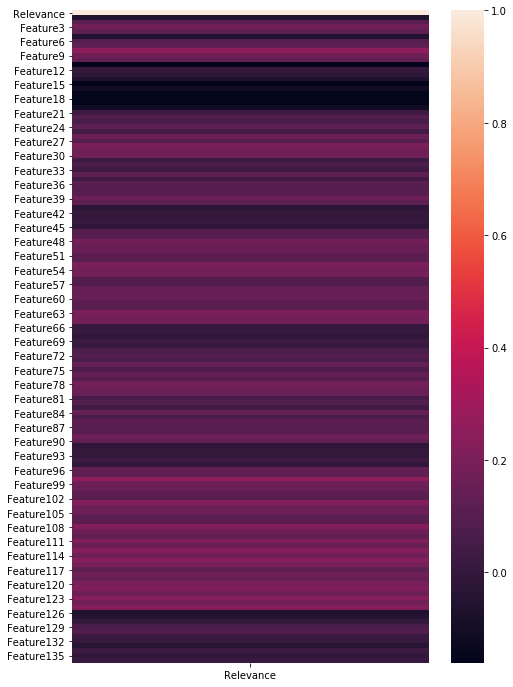

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize = (8,12))
_ = sns.heatmap(df.corr()[['Relevance']])

In [51]:
df.corr()[['Relevance']].sort_values(by='Relevance', ascending=False).head(n=10)

,Relevance
Relevance,1.000000
Feature98,0.257401
Feature8,0.254079
Feature123,0.237891
Feature115,0.230539
Feature113,0.228610
Feature108,0.222890
Feature125,0.222312
Feature103,0.220817
Feature111,0.218642


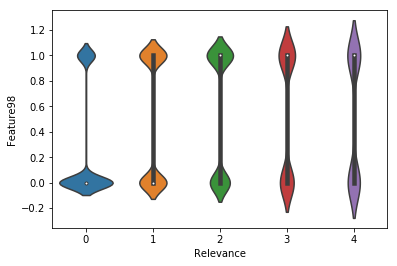

In [43]:
_ = sns.violinplot(x='Relevance', y='Feature98', data=df)

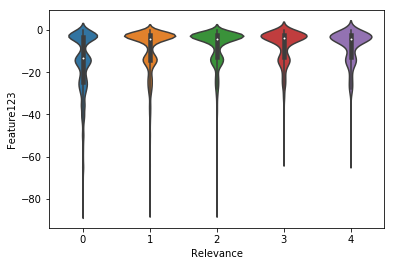

In [44]:
_ = sns.violinplot(x='Relevance', y='Feature123', data=df)

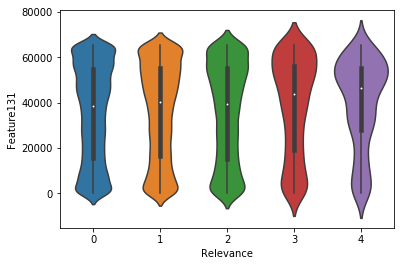

In [56]:
_ = sns.violinplot(x='Relevance', y='Feature131', data=df)

In [7]:
import numpy as np

y = df['Relevance']
groups = df['QueryID']
X = df.drop(['Relevance', 'QueryID'], axis=1)

unique_groups = groups.unique()
train_groups = np.random.choice(unique_groups, size=int(len(unique_groups)*0.75))

train_indices = groups.map(lambda z: z in train_groups)
test_indices = groups.map(lambda z: z not in train_groups)

X_train = X[train_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]

groups_train = groups[train_indices]
groups_test = groups[test_indices]
                     
groups_train = pd.Series(groups_train).groupby(groups_train).size()
groups_test = pd.Series(groups_test).groupby(groups_test).size()

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np

y = df['Relevance']
groups = df['QueryID']
X = df.drop(['Relevance', 'QueryID'], axis=1)

Xt, Xv, yt, yv, gt, gv = train_test_split(X, y, groups, shuffle=False)

gt = pd.Series(gt).groupby(gt).size()
gv = pd.Series(gv).groupby(gv).size()

In [23]:
from lightgbm import LGBMRanker

model = LGBMRanker(n_estimators=250, num_leaves=7, colsample_bytree=0.5)

#model.fit(Xt, yt, group=gt, eval_set=[(Xv, yv), (Xt, yt)], eval_group=[gv, gt], eval_at=[10], verbose=25)
model.fit(X_train, y_train, group=groups_train,
          eval_set=[(X_test, y_test), (X_train, y_train)], eval_group=[groups_test, groups_train],
          eval_at=[10], verbose=25)

[25]	training's ndcg@10: 0.453865	valid_0's ndcg@10: 0.438752
[50]	training's ndcg@10: 0.475352	valid_0's ndcg@10: 0.453537
[75]	training's ndcg@10: 0.488109	valid_0's ndcg@10: 0.460427
[100]	training's ndcg@10: 0.498753	valid_0's ndcg@10: 0.466308
[125]	training's ndcg@10: 0.511002	valid_0's ndcg@10: 0.472087
[150]	training's ndcg@10: 0.520839	valid_0's ndcg@10: 0.472828
[175]	training's ndcg@10: 0.530597	valid_0's ndcg@10: 0.474389
[200]	training's ndcg@10: 0.537488	valid_0's ndcg@10: 0.476489
[225]	training's ndcg@10: 0.544812	valid_0's ndcg@10: 0.478239
[250]	training's ndcg@10: 0.551877	valid_0's ndcg@10: 0.478659


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
      learning_rate=0.1, max_depth=-1, min_child_samples=20,
      min_child_weight=0.001, min_split_gain=0.0, n_estimators=250,
      n_jobs=-1, num_leaves=7, objective=None, random_state=None,
      reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
      subsample_for_bin=200000, subsample_freq=1)

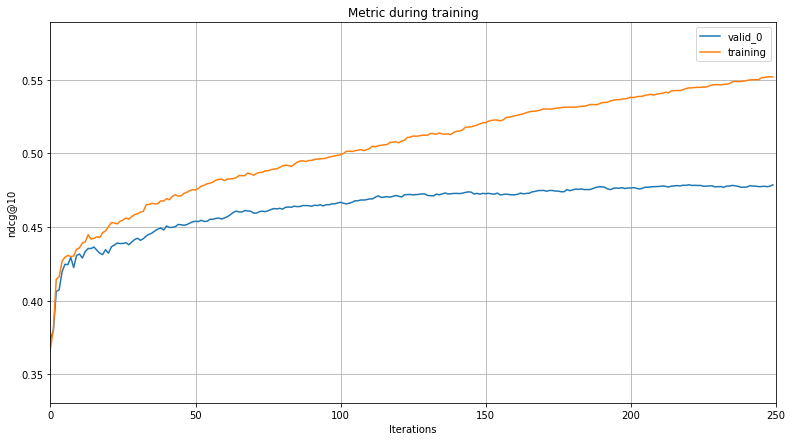

In [24]:
from lightgbm import plot_metric

plot_metric(model, metric='ndcg@10', figsize=(13,7))

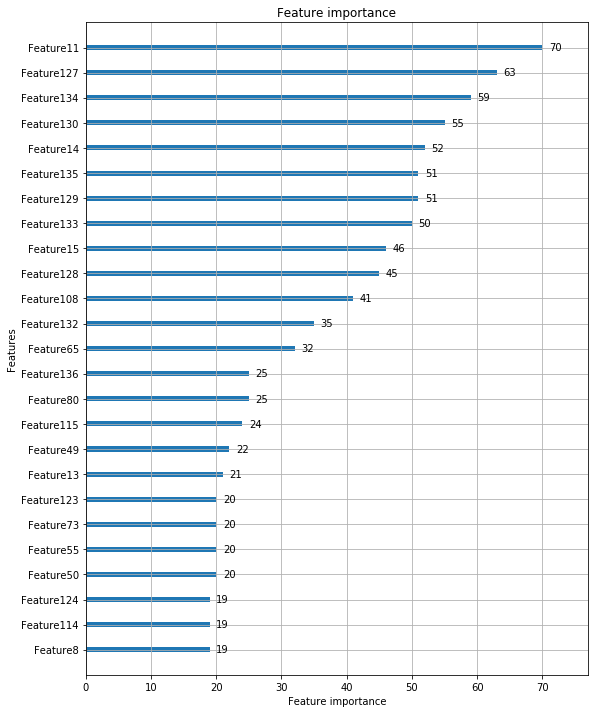

In [25]:
from lightgbm import plot_importance

plot_importance(model, max_num_features=25, figsize=(9,12))